In [1]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
from helper import get_cat_count, count_parameters, compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [2]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                # transforms.RandomCrop((64, 64)),
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.75, 1.0), ratio=(0.75, 1.3)), # original 80*80, avoid cropping important info
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
                ## T.RandomErasing(),
                ## T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                ## T.RandomInvert(p=0.05),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                # transforms.CenterCrop((64, 64)),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## transforms.Normalize([0.485, 0.456, 0.406],
                ##                                 [0.229, 0.224, 0.225]),
            ]
        )

In [7]:
#################################################################################
#####                      Specify NN to be used                           ######
#################################################################################

### Simplified implementation of VGG16 with 12 layers instead of 16.
### Cut layer = 256 - 256 conv layer. 512-512 * 3 conv layers at the end.
### Reduced number of nodes on FC layer from 4096 to 1024.
vgg_12 = [64, 64, 'maxpool', 128, 128, 'maxpool', 256, 256, 'maxpool', 512, 512, 512, 'maxpool', 'avgpool', 'fc1', 'fc2', 'fc3']    
##########################################################################################
# trying to take some inspirations from vgg16 but with less channels and fc layer nodes. #
##########################################################################################
class VGG12(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            ######### block 1 #########
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 2 #########
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            ######### block 3 #########   
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 4 #########
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2))
        )
        
        # shrink final conv layer width to 4
        self.avgpool = nn.AdaptiveAvgPool2d((3,3))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(512*3*3, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Dropout(p=0.6),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        
            nn.Dropout(p=0.4),
            nn.Linear(1024, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)       
    

####################################################################################################################
# Re-implementation of AlexNet                                                                                     #
# https://github.com/pytorch/vision/blob/693829121bdc3e26714691f70241c6c01a089457/torchvision/models/alexnet.py    #
# Added Batch normalization, Leaky ReLU to prevent overfitting, reduced neurons in Hidden FC Layers for size res.  #
####################################################################################################################
class AlexNetModified(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((2, 2), stride=2)
        )
        
        # shrink final conv layer width to 6
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(256*6*6, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.2),
            nn.Linear(1000, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x
    
        
net = VGG12()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.0005
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 200
epochs = 200


###############################################
#**          Print Network Information      **#
###############################################
print(transform('train'))
print(net)
count_parameters(net)

Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.75, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.2, 0.2])
    RandomPosterize(bits=3,p=0.4)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.1)
    RandomPerspective(p=0.1)
    ToTensor()
)
VGG12(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, ker

12831560

### Plotting Helper functions

## HW 2 Main

In [8]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###########################
## Cat breed dictionary  ##
###########################
cat_dict = {
    0: 'bombay',
    1: 'calico',
    2: 'persian',
    3: 'russianblue',
    4: 'siamese',
    5: 'tiger',
    6: 'tortoiseshell',
    7: 'tuxedo'
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Test network on validation set, if it exists.
## Added params
def test_network(net,testloader,test_accuracy_list,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

In [9]:
##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################



# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)


# Get model, loss criterion and optimizer from student
net = net.to(device)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  ## Added

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100 
    train_accuracy_list.append(model_accuracy)  ## Added
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0)) ## Added
    else:
        print()
    
    time_elapsed = time.time() - start_time  ## Added Line
    print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## Added
    
    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

time_elapsed = time.time() - start_time ## Added Line
print(f'total time needed to train network: {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}') ## Added Line
torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")



Using device: cuda:0

Start training...
ep 1, loss: 62.96, 6400 train 23.38%, 1600 test 18.94%
Time elapsed: 0:00:24.442601
ep 2, loss: 56.41, 6400 train 31.95%, 1600 test 34.50%
Time elapsed: 0:00:48.530882
ep 3, loss: 53.46, 6400 train 36.56%, 1600 test 38.88%
Time elapsed: 0:01:13.134095
ep 4, loss: 49.56, 6400 train 41.31%, 1600 test 40.75%
Time elapsed: 0:01:37.087476
ep 5, loss: 46.32, 6400 train 45.72%, 1600 test 52.62%
Time elapsed: 0:02:01.364473
ep 6, loss: 43.12, 6400 train 50.23%, 1600 test 36.50%
Time elapsed: 0:02:23.658573
ep 7, loss: 40.97, 6400 train 52.88%, 1600 test 50.00%
Time elapsed: 0:02:45.847716
ep 8, loss: 39.33, 6400 train 55.03%, 1600 test 48.25%
Time elapsed: 0:03:08.002042
ep 9, loss: 36.62, 6400 train 58.86%, 1600 test 50.38%
Time elapsed: 0:03:30.244464
ep 10, loss: 35.21, 6400 train 60.03%, 1600 test 50.50%
[[186.   0.   0.   3.   4.   1.  11.   0.]
 [  7.  20.  43.   2.   6.  68.  45.   2.]
 [ 17.   1. 134.   6.   7.  22.  18.   0.]
 [ 42.   0.  25.  7

ep 71, loss: 6.17, 6400 train 93.25%, 1600 test 77.56%
Time elapsed: 0:29:01.306489
ep 72, loss: 7.25, 6400 train 92.47%, 1600 test 81.56%
Time elapsed: 0:29:23.581358
ep 73, loss: 6.34, 6400 train 93.59%, 1600 test 80.44%
Time elapsed: 0:29:45.832465
ep 74, loss: 6.49, 6400 train 93.17%, 1600 test 78.69%
Time elapsed: 0:30:08.153780
ep 75, loss: 5.96, 6400 train 93.31%, 1600 test 79.50%
Time elapsed: 0:30:30.405459
ep 76, loss: 5.64, 6400 train 93.86%, 1600 test 80.62%
Time elapsed: 0:30:52.722705
ep 77, loss: 6.03, 6400 train 93.38%, 1600 test 81.94%
Time elapsed: 0:31:15.016319
ep 78, loss: 6.11, 6400 train 93.55%, 1600 test 79.81%
Time elapsed: 0:31:37.887481
ep 79, loss: 5.72, 6400 train 94.08%, 1600 test 76.06%
Time elapsed: 0:32:00.375506
ep 80, loss: 5.86, 6400 train 93.67%, 1600 test 81.94%
[[178.   2.   1.   8.   3.   1.   7.   5.]
 [  2. 155.   4.   2.  11.   5.   8.   6.]
 [  6.  13. 158.   4.  10.   5.   5.   4.]
 [  7.   4.   5. 175.   6.   2.   5.   1.]
 [  2.  15.  16. 

ep 141, loss: 2.97, 6400 train 96.91%, 1600 test 80.75%
Time elapsed: 0:55:15.436247
ep 142, loss: 2.53, 6400 train 97.16%, 1600 test 82.31%
Time elapsed: 0:55:37.500776
ep 143, loss: 2.55, 6400 train 97.48%, 1600 test 79.44%
Time elapsed: 0:55:59.524047
ep 144, loss: 2.52, 6400 train 97.44%, 1600 test 81.81%
Time elapsed: 0:56:21.667282
ep 145, loss: 2.77, 6400 train 97.14%, 1600 test 79.19%
Time elapsed: 0:56:43.728793
ep 146, loss: 2.82, 6400 train 97.16%, 1600 test 79.69%
Time elapsed: 0:57:05.767911
ep 147, loss: 3.03, 6400 train 96.91%, 1600 test 75.44%
Time elapsed: 0:57:27.841095
ep 148, loss: 2.88, 6400 train 97.03%, 1600 test 81.00%
Time elapsed: 0:57:49.897761
ep 149, loss: 2.77, 6400 train 97.17%, 1600 test 79.44%
Time elapsed: 0:58:11.979143
ep 150, loss: 3.04, 6400 train 96.73%, 1600 test 80.06%
[[165.   2.   2.  20.   2.   1.   1.  12.]
 [  2. 132.   8.   5.   6.  11.   5.  24.]
 [  2.   9. 170.   7.   6.   2.   3.   6.]
 [  1.   2.   5. 185.   3.   3.   2.   4.]
 [  1. 

### Analysis

batch size: 200
learning rate: 0.0005
train_val_split: 0.8
epochs: 200
training data - total instances = 6400
test data - total instances = 1600
training data distribution - {0: 795, 1: 807, 2: 795, 3: 795, 4: 794, 5: 811, 6: 790, 7: 813}
test data distribution - {0: 205, 1: 193, 2: 205, 3: 205, 4: 206, 5: 189, 6: 210, 7: 187}


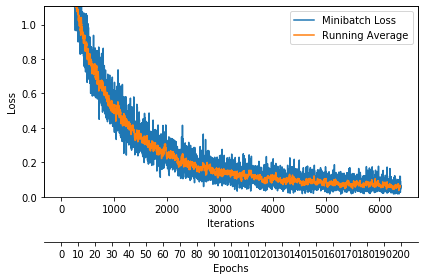

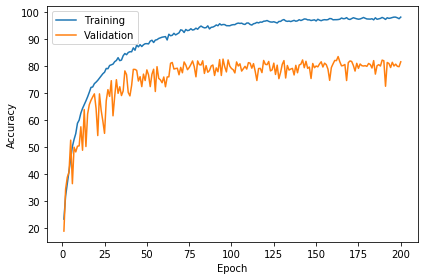

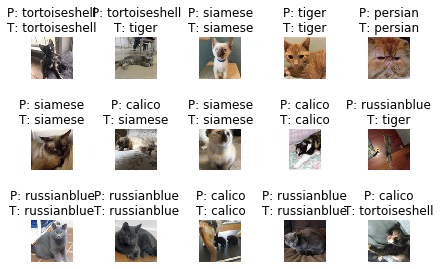

[[175   4   2   2   2   0  11   9]
 [  1 149   3   2   6  13  15   4]
 [  4  10 158   6   8   6   7   6]
 [  4   6   5 172   2   6   6   4]
 [  0  13   8   7 173   0   2   3]
 [  3   8   1   3   0 169   2   3]
 [  4  21   6   6   0   7 163   3]
 [  5  20   1   1   4   1   0 155]]


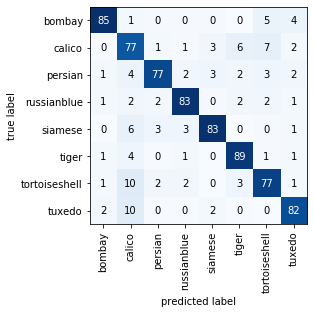

In [10]:
###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
print(conf_matrix)
plot_confusion_matrix(conf_matrix, class_names=cat_dict.values(), test_data_distribution=test_data_distribution)
plt.show()